# Тематическая модель [Постнауки](http://postnauka.ru)
## Peer Review (optional)

В этом задании мы применим аппарат тематического моделирования к коллекции текстовых записей видеолекций, скачанных с сайта Постнаука. Мы будем визуализировать модель и создавать прототип тематического навигатора по коллекции. В коллекции 1728 документов, размер словаря - 38467 слов. Слова лемматизированы, то есть приведены к начальной форме, с помощью программы [mystem](https://tech.yandex.ru/mystem/), коллекция сохранена в [формате vowpal wabbit](http://docs.bigartm.org/en/latest/formats.html). В каждой строке до первой черты записана информация о документе (ссылка на страницу с лекцией), после первой черты следует описание документа. Используются две модальности - текстовая ("text") и модальность авторов ("author"); у каждого документа один автор.

Для выполнения задания понадобится библиотека [BigARTM](http://docs.bigartm.org). В демонстрации показан пример использования библиотеки версии 0.7.4, на сайте предлагается скачивать версию 0.8.0. В новой версии изменены принципы работы со словарями: они вынесены в отдельный класс (пример в [Release Notes](http://docs.bigartm.org/en/stable/release_notes/python.html)). Строить модель и извлекать ее параметры нужно так же, как показано в демонстрации. Вы можете использовать [предыдущий релиз](http://bigartm.readthedocs.io/en/v0.7.6/download.html) или [новый релиз](http://docs.bigartm.org/en/latest/download.html) на ваше усмотрение.

Спецификации всех функций вы можете смотреть на странице [Python API](http://bigartm.readthedocs.io/en/stable/python_interface.html).

In [135]:
import artm

In [136]:
from matplotlib import pyplot as plt
import seaborn
%matplotlib inline
seaborn.set_style("whitegrid", {'axes.grid' : False})

In [137]:
import numpy as np
import pandas as pd

##### Считывание данных

Создайте объект класса artm.BatchVectorizer, который будет ссылаться на директорию с пакетами данных (батчами). Чтобы библиотека могла преобразовать текстовый файл в батчи, создайте пустую директорию и укажите ее название в параметре target_folder. Размер батча для небольших коллекций (как наша) не важен, вы можете указать любой.

In [138]:
# Ваш код
batch_vectorizer = artm.BatchVectorizer(data_path="lectures.txt",
                                        data_format="vowpal_wabbit",
                                        target_folder="lectures_batches",
                                        batch_size=100
                                       )

##### Инициализация модели

Создайте объект класса artm.Model с 30 темами, именами тем, указанными ниже и единичными весами обеих модальностей. Количество тем выбрано не очень большим, чтобы вам было удобнее работать с темами. На этой коллекции можно строить и большее число тем, тогда они будут более узко специализированы.

In [139]:
T = 30   # количество тем
topic_names=["sbj"+str(i) for i in range(T-1)]+["bcg"]
# Ваш код
model_artm = artm.ARTM(num_topics=T,
                       topic_names=topic_names,
                       class_ids={'text', 'author'}, 
                       num_document_passes=1,
                       reuse_theta=True,
                       cache_theta=True,
                       seed=-1
                      )

Мы будем строить 29 предметных тем и одну фоновую. 

Соберите словарь с помощью метода gather_dictionary и инициализируйте модель, указав random_seed=1. Обязательно укажите свое название словаря, оно понадобится при добавлении регуляризаторов.

In [140]:
# Ваш код
np.random.seed(1)
dictionary = artm.Dictionary('dictionary_myself')
dictionary.gather(batch_vectorizer.data_path)

##### Добавление score

Создайте два измерителя качества artm.TopTokensScore - по одному для каждой модальности; количество токенов 15. Названия для score придумайте самостоятельно.

In [141]:
# Ваш код
model_artm.scores.add(artm.TopTokensScore(name="top_words_text", num_tokens=15, class_id="text"))
model_artm.scores.add(artm.TopTokensScore(name="top_words_authors", num_tokens=15, class_id="author"))

In [142]:
model_artm.initialize('dictionary_myself')
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

##### Построение модели

Мы будем строить модель в два этапа: сначала добавим сглаживающий регуляризатор фоновой темы и настроим параметры модели, затем - добавим разреживающий регуляризатор предметрых тем и выполним еще несколько итераций. Так мы сможем получить наиболее чистые от фоновых слов предметные темы. Сглаживающий и разреживающий регуляризаторы задаются одним и тем же классом artm.SmoothSparsePhiRegularizer: если коэффициент tau положительный, то регуляризатор будет сглаживающий, если отрицательный - разреживающий.

Если вы хотите подробнее разобраться, как выполняется регуляризация тематической модели в BigARTM, вы можете прочитать [статью](https://s3-eu-west-1.amazonaws.com/artm/voron-potap14artm-rus.pdf), раздел 4.

Добавьте сглаживающий регуляризатор с коэффициентом tau = 1e5, указав название своего словаря в dictionary, модальность текста в class_ids и тему "bcg" в topic_names.

In [143]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='Smooth_noise',
                                                            tau = 1e5,
                                                            dictionary=dictionary,
                                                            class_ids='text',
                                                            topic_names=['bcg']))

Выполните 30 итераций по коллекции (num_collection_passes), количество внутренних итераций установите равным 1. Используйте метод fit_offline модели.

In [144]:
# Ваш код
model_artm.initialize('dictionary_myself')
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=30)

Добавьте разреживающий регуляризатор с коэффициентом tau=-1e5, указав название своего словаря, модальность текста в class_ids и все темы "sbjX" в topic_names.

In [145]:
# Ваш код
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='Sparse_main',
                                                            tau = -1e5,
                                                            dictionary=dictionary,
                                                            class_ids='text',
                                                            topic_names=topic_names
                                                           ))

Выполните еще 15 проходов по коллекции.

In [146]:
# Ваш код
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

##### Интерпретация тем

Используя созданные score, выведите топы слов и топы авторов в темах. Удобнее всего выводить топ слов каждой темы с новой строки, указывая название темы в начале строки, и аналогично с авторами.

In [147]:
# Ваш код
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker['top_words_text'].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  церковь власть средневековый император русь святой письмо александр папа князь сага римский славянский византийский рим
sbj1:  планета земля атмосфера солнце солнечный белый размер карлик газ вода образовываться вокруг поверхность орбита градус
sbj2:  система трудность образование двигаться поведение движение частота точность относительность тест стандарт единица час измерение моделирование
sbj3:  культура понятие культурный рассказывать восприятие сознание феномен личность воспринимать ощущение чувство мария переживание повлиять этика
sbj4:  право правовой римский юрист юридический должник собственность обязательство владение требование исполнение договор собственник имущество критерий
sbj5:  материал структура атом свет свойство молекула применение поверхность углерод оптический полимер импульс кристалл электронный прибор
sbj6:  литература фильм литературный автор произведение кино написать искусство герой жанр писатель академия кинематограф театр документ
sbj7:  смерть ритуал

In [148]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker['top_words_authors'].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  Александр_Марей Фёдор_Успенский Павел_Уваров Татьяна_Бобровникова Алексей_Юдин Игорь_Данилевский Елена_Уханова Владимир_Петрухин Ольга_Брилева Ольга_Вайнштейн Арчил_Балахванцев Екатерина_Болтунова Алексей_Гиппиус Ольга_Тогоева Олег_Воскобойников
sbj1:  Сергей_Попов Зоригто_Намсараев Владимир_Кузнецов Татьяна_Смоктунович Дмитрий_Титов Андрей_Иванцов Александр_Марков Николай_Дронин Сергей_Писарев Александр_Слободкин Александр_Кислов Елизавета_Ривкина Роман_Рафиков Дмитрий_Вибе Владимир_Сурдин
sbj2:  Елена_Брызгалина Эмиль_Ахмедов Александр_Поддьяков Владимир_Мележик Михаил_Пантелеев Юджин_Ползик Виталий_Пальчиков Михаил_Фейгельман Даниэль_Сельва Владимир_Редько Инга_Полетаева Татьяна_Клячко Илья_Щуров Кристофер_Уиншип Мартин_Вейс
sbj3:  Виталий_Куренной Михаил_Соколов Ольга_Артёмова Александр_Доброхотов Владимир_Миронов Пётр_Турчин Ирина_Савельева Алексей_Руткевич Николай_Плотников Кирилл_Разлогов Владимир_Каганский Сергей_Соколовский Сергей_Арутюнов Александр_Мещеряков Фёдор_Гире

В посtextледней теме "bcg" должны находиться общеупотребительные слова.

Важный шаг в работе с тематической моделью, когда речь идет о визуализации или создании тематического навигатора, это именование тем. Понять, о чем каждая тема, можно по списку ее топовых слов. Например, тему
    
    частица взаимодействие физика кварк симметрия элементарный нейтрино стандартный материя протон бозон заряд масса ускоритель слабый
    
можно назвать "Физика элементарных частиц". 

Дайте названия 29 предметным темам. Если вы не знаете, как назвать тему, назовите ее первым встретившимся в ней существительным, хотя при таком подходе навигатор будет менее информативным. Из названий тем составьте список из 29 строк и запишите го в переменную sbj_topic_labels. В переменной topic_labels будут храниться названия всех тем, включая фоновую.

In [149]:
sbj_topic_labels = []

for topic_name in model_artm.topic_names:
    tokens = model_artm.score_tracker['top_words_text'].last_tokens
    sbj_topic_labels.append(tokens[topic_name][0])
sbj_topic_labels.pop()
# запишите названия тем в список
topic_labels = sbj_topic_labels + ["Фоновая тема"]

##### Анализ тем

Далее мы будем работать с распределениями тем в документах (матрица $\Theta$) и авторов в темах (одна из двух матриц $\Phi$, соответствующая модальности авторов). 
Создайте переменные, содержащие две этих матрицы, с помощью методов get_phi и get_theta модели. Назовите переменные theta и phi_a. Выведите формы обеих матриц, чтобы понять, по каким осям стоят темы.

In [150]:
model_artm.theta_columns_naming = "title" # включает именование столбцов Theta их названиями-ссылками, а не внутренними id 
# Ваш код
phi_a = model_artm.get_phi(class_ids='author')
theta = model_artm.get_theta()
phi_a.head()

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
"(author, Сергей_Зыков)",0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.022832,0.0,0.0,0.0,0.0,0.0,0.000000
"(author, Олег_Лукин)",0.0,0.0,0.0,0.000000,0.0,0.015289,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
"(author, Джозеф_Браун)",0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.022832,0.0,0.0,0.0,0.0,0.0,0.000000
"(author, Зоя_Зорина)",0.0,0.0,0.0,0.023219,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
"(author, Яков_Тестелец)",0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.018555


In [151]:

theta.head()

,http://postnauka.ru/video/53046,http://postnauka.ru/video/53169,http://postnauka.ru/video/53171,http://postnauka.ru/video/532,http://postnauka.ru/video/53228,http://postnauka.ru/video/53298,http://postnauka.ru/video/53342,http://postnauka.ru/video/53364,http://postnauka.ru/video/53386,http://postnauka.ru/video/53415,...,http://postnauka.ru/video/47550,http://postnauka.ru/video/47551,http://postnauka.ru/video/478,http://postnauka.ru/video/47810,http://postnauka.ru/video/47812,http://postnauka.ru/video/47814,http://postnauka.ru/video/47816,http://postnauka.ru/video/47818,http://postnauka.ru/video/47819,http://postnauka.ru/video/47821
sbj0,0.000211,0.000000,0.000468,0.000000,2.182351e-01,0.000000e+00,0.000000e+00,2.502384e-05,0.000000e+00,0.0000,...,1.336475e-09,2.850646e-15,0.000000,0.000000e+00,1.457371e-03,0.006899,3.192480e-03,0.000000e+00,0.000000,8.467152e-04
sbj1,0.000000,0.000000,0.000000,0.000000,3.571327e-10,9.316657e-07,9.362868e-03,0.000000e+00,3.283438e-04,0.0000,...,1.488429e-03,1.601476e-08,0.007203,2.203783e-09,1.434733e-03,0.012617,2.489466e-03,0.000000e+00,0.012916,0.000000e+00
sbj2,0.003982,0.000000,0.000000,0.010033,1.063904e-14,4.302314e-03,3.595427e-06,6.371283e-16,1.023898e-02,0.0625,...,1.029561e-11,1.109360e-02,0.000000,1.388858e-02,1.692074e-08,0.006153,7.162435e-16,9.834821e-04,0.003255,4.972578e-03
sbj3,0.017677,0.011136,0.000000,0.020407,2.572063e-03,6.216036e-11,1.054828e-16,4.340164e-03,3.331890e-15,0.0000,...,0.000000e+00,6.600635e-03,0.000821,3.625419e-03,1.690574e-01,0.007236,2.522276e-03,9.510844e-15,0.000000,1.045124e-05
sbj4,0.003876,0.000000,0.000000,0.000000,2.584206e-03,8.772411e-04,7.925553e-16,1.847217e-04,2.125108e-14,0.0000,...,9.270549e-14,2.540837e-04,0.000000,1.235293e-06,9.674070e-03,0.000838,1.092201e-03,2.195660e-13,0.000000,1.760410e-08


Визуализируем фрагмент матрицы $\Theta$ - первые 100 документов (это наиболее простой способ визуально оценить, как темы распределяются в документах). С помощью метода seaborn.heatmap выведите фрагмент theta как изображение. Рекомендация: создайте фигуру pyplot размера (20, 10).

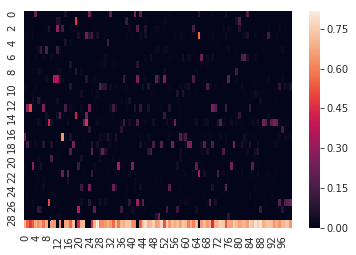

In [152]:
# Ваш код
import seaborn as sns
sns.heatmap(theta.to_numpy()[:, 0:100])

Вы должны увидеть, что фоновая тема имеет большую вероятность в почти каждом документе, и это логично. Кроме того, есть еще одна тема, которая чаще других встречается в документах. Судя по всему, это тема содержит много слов по науку в целом, а каждый документ (видео) в нашей коллекции связан с наукой. Можно (необязательно) дать этой теме название "Наука".

Помимо этих двух тем, фоновой и общенаучной, каждый документ характеризуется малым числом других тем.

Оценим $p(t)$ - долю каждой темы во всей коллекции. По формуле полной вероятности вычислять эти величины нужно как
$p(t) = \sum_d p(t|d) p(d)$. Согласно вероятностной модели, $p(d)$ пропорционально длине документа d. Поступим проще: будем полагать, что все документы равновероятны. Тогда оценить $p(t)$ можно, просуммировав $p(t|d)$ по всем документам, а затем разделив полученный вектор на его сумму. 

Создайте переменную-датафрейм с T строками, индексированными названиями тем, и 1 столбцом, содержащим оценки $p(t)$. Выведите датафрейм на печать.

In [153]:
# Ваш код
p = np.sum(theta.to_numpy(), axis = 1)
for i in range(len(p)):
    p[i] /= len(p)
    
d = {'p(t)': p}
df = pd.DataFrame(data=d)
df.index = topic_labels
df.head()

,p(t)
церковь,0.764137
планета,0.845660
система,0.595428
культура,1.854760
право,0.510391


Найдите 5 самых распространенных и 3 наименее освещенных темы в коллекции (наибольшие и наименьшие $p(t)$ соответственно), не считая фоновую и общенаучную. Укажите названия, которые вы дали этим темам.

In [154]:
print df

                   p(t)
церковь        0.764137
планета        0.845660
система        0.595428
культура       1.854760
право          0.510391
материал       0.910234
литература     0.520990
смерть         0.239610
химический     1.540662
частица        1.589745
война          1.001113
ребенок        0.532110
растение       0.581857
территория     1.147431
звезда         1.171160
задача         1.088510
раса           0.414724
политический   1.274591
язык           0.891074
революция      0.335864
город          0.834478
болезнь        0.704275
социальный     0.948120
схема          0.508817
бог            0.771878
программа      0.213440
страна         0.945599
клетка         1.760498
университет    0.477845
Фоновая тема  32.625000


Визуализируйте матрицу $\Phi$ модальности авторов в виде изображения. Рекомендация: установите yticklabels=False в heatmap.

In [155]:
phi_a.head()

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9,...,sbj20,sbj21,sbj22,sbj23,sbj24,sbj25,sbj26,sbj27,sbj28,bcg
"(author, Сергей_Зыков)",0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.022832,0.0,0.0,0.0,0.0,0.0,0.000000
"(author, Олег_Лукин)",0.0,0.0,0.0,0.000000,0.0,0.015289,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
"(author, Джозеф_Браун)",0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.022832,0.0,0.0,0.0,0.0,0.0,0.000000
"(author, Зоя_Зорина)",0.0,0.0,0.0,0.023219,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
"(author, Яков_Тестелец)",0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.018555


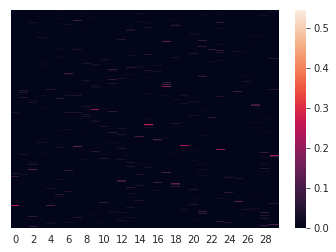

In [156]:
# Ваш код
sns.heatmap(phi_a.to_numpy()[:, 0:100], yticklabels=False)

Каждой теме соответствует не очень большое число авторов - матрица достаточно разреженная. Кроме того, некоторые темы имеют доминирующего автора $a$, имеющего большую вероятность $p(a|t)$ - этот автор записал больше всего лекций по теме. 

In [157]:
for column in phi_a.T.columns.values:
    n =phi_a.T[ phi_a.T[column] > 0.01].shape[0]
    if n >=3:
        print column[1]
    #print phi_a.T[column]

Иван_Воробьев
Андрей_Цатурян
Михаил_Соколов
Алина_Бодрова
Михаил_Маяцкий
Ольга_Вайнштейн
Павел_Нерлер_(Полян)
Андрей_Кофман
Илья_Иткин
Алексей_Желтиков
Андрей_Журавлев
Татьяна_Ребеко
Дэвид_Кайзер


Будем считать, что автор $a$ значим в теме, если $p(a|t) > 0.01$. Для каждого автора посчитайте, в скольких темах он значим. Найдите авторов-рекордсменов, которые значимы (а значит, читали лекции) в >= 3 темах.

Большинство авторов значимы в 1 теме, что логично.

##### Построение тематической карты авторов

По сути, в матрице $\Phi$, соответствующей модальности авторов, записаны тематические кластеры авторов. Для любого автора мы можем составить его тематический круг - авторов, разбирающихся в той же теме, что и данный. Интересующиеся слушатели могут попробовать выполнить эту процедуру для ученых, читающих лекции на Постнауке, которых они знают (например, на Постнауке есть лекции с К. В. Воронцовым - лектором текущего модуля :)

Составим карту близости авторов по тематике их исследований. Для этого применим метод понижения размерности MDS к тематическим профилям авторов.

Чтобы получить тематический профиль автора, распределение $p(t|a)$, нужно воспользоваться формулой Байеса: 
$p(t|a) = \frac {p(a|t) p(t)} {\sum_{t'} p(a|t') p(t')}$. Все необходимые для этого величины у вас есть и записаны в переменных phi и pt. 

Передайте матрицу тематических профилей авторов, записанных по строкам, в метод MDS с n_components=2. Используйте косинусную метрику (она хорошо подходит для поиска расстояний между векторами, имеющими фиксированную сумму компонент).

In [158]:
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances

In [159]:
# Ваш код
auth_profile = phi_a.to_numpy()
nump_p = np.asarray(p)
print auth_profile.shape
for auth in range(auth_profile.shape[0]):
    down =  np.dot(phi_a.to_numpy()[auth, :], nump_p)
    for topic in range(auth_profile.shape[1]):
        up = phi_a.to_numpy()[auth, topic]
        auth_profile[auth, topic] = up / down


(539, 30)


Визуализируйте найденные двумерные представления с помощью функции scatter. 

Populating the interactive namespace from numpy and matplotlib


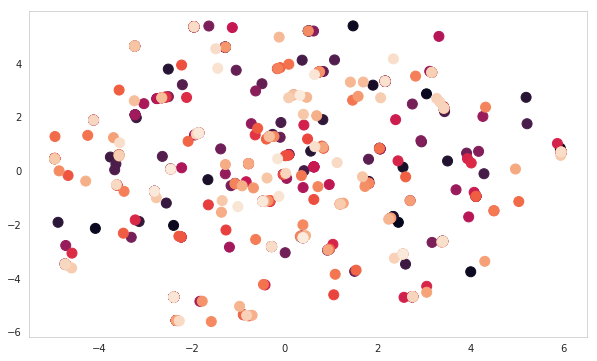

In [160]:
# Ваш код
%pylab inline
data = pairwise_distances(auth_profile, metric='cosine')
mds = MDS(n_components = 2, n_init = 1, max_iter = 100)
data_2d_mds = mds.fit_transform(data.astype(np.float64))

pylab.figure(figsize=(10, 6))
pylab.scatter(data_2d_mds[:, 0], data_2d_mds[:, 1], c = range(539), s=100)

Должно получиться, что некоторые грппы авторов формируют сгустки, которые можно считать тематическими группами авторов.

Раскрасим точки следующим образом: для каждого автора выберем наиболее вероятную для него тему ($\max_t p(t|a)$), и каждой теме сопоставим цвет. Кроме того, добавим на карту имена и фамилии авторов, это можно сделать в цикле по всем точкам с помощью функции plt.annotate, указывая метку точки первым аргументом и ее координаты в аргументе xy. Рекомендуется сделать размер изображения большим, тогда маркеры точек тоже придется увеличить (s=100 в plt.scatter). Изобразите карту авторов и сохраните в pdf-файл с помощью функции plt.savefig. 

Метки авторов будут пересекаться. Будет очень хорошо, если вы найдете способ, как этого можно избежать.

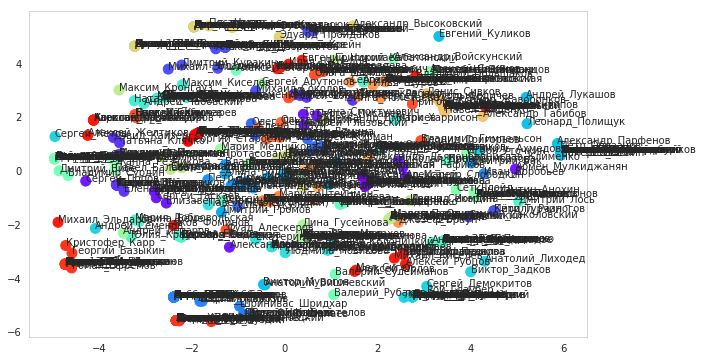

In [161]:
 # цвета для тем
# Ваш код
import matplotlib.cm as cm
colors = cm.rainbow(np.linspace(0, 1, T))

auth_color = []
for auth in range(auth_profile.shape[0]):
    top = auth_profile[auth, :].tolist().index(max(auth_profile[auth, :].tolist()))
    auth_color.append(colors[top])
    
plt.figure(figsize=(10, 6))
plt.scatter(data_2d_mds[:, 0], data_2d_mds[:, 1], c = auth_color, s=100)


authors = phi_a.T.columns.values
for i, txt in enumerate(authors):
    plt.annotate(txt[1], (data_2d_mds[i, 0], data_2d_mds[i, 1]))
plt.savefig('plot.pdf')

##### Создание простого тематического навигатора по Постнауке

Наш тематический навигатор будет для каждой темы показывать ее список слов, а также список релевантных теме документов. 

Нам понадобятся распределения $p(d|t)$. По формуле Байеса $p(d|t) = \frac{p(t|d)p(d)}{\sum_{d'}p(t|d')p(d')}$, но поскольку мы считаем документы равновероятными, достаточно разделить каждую строку $\Theta$ на ее сумму, чтобы оценить распределение. 

Отсортируйте матрицу $p(d|t)$ по убыванию $p(d|t)$ в каждой теме (то есть построчно). Нам понадобятся индексы наиболее вероятных документов в каждой теме, поэтому используйте функцию argmax.

In [162]:
doc_topic = theta.to_numpy()
print theta.to_numpy().shape

(30, 1728)


In [163]:
# Ваш код
doc_topic = theta.to_numpy()
one = np.ones((1728,1))
for topic in range(doc_topic.shape[0]):
    down =  sum(theta.to_numpy()[topic, :].tolist())
    for doc in range(doc_topic.shape[1]):
        up = theta.to_numpy()[topic, doc] 
        doc_topic[topic, doc] = up / down

#most_prob_doc = 

Создавать навигатор мы будем прямо в jupiter notebook: это возможно благодаря тому факту, что при печати ссылки она автоматически превращается в гиперссылку.

In [164]:
print "http://yandex.ru"   # получится кликабельная ссылка

http://yandex.ru


Кроме того, подключив модуль [ipython.core.display](https://ipython.org/ipython-doc/2/api/generated/IPython.core.display.html), можно использовать html-разметку в выводе. Например:

In [165]:
from IPython.core.display import display, HTML
display(HTML(u"<h1>Заголовок</h1>"))   # также <h2>, <h3>
display(HTML(u"<ul><li>Пункт 1</li><li>Пункт 2</li></ul>"))
display(HTML(u'<font color="green">Зеленый!</font>'))
display(HTML(u'<a href="http://yandex.ru">Еще один вариант вывода ссылки</a>'))

В цикле для каждой темы выведите ее заголовок, в следующей строке - топ-10 слов темы, затем в виде списка ссылки на 10 наиболее релевантных (по $p(d|t)$) теме документов. Используйте html-разметку. Творчество приветствуется :)

In [166]:
theta.head()

,http://postnauka.ru/video/53046,http://postnauka.ru/video/53169,http://postnauka.ru/video/53171,http://postnauka.ru/video/532,http://postnauka.ru/video/53228,http://postnauka.ru/video/53298,http://postnauka.ru/video/53342,http://postnauka.ru/video/53364,http://postnauka.ru/video/53386,http://postnauka.ru/video/53415,...,http://postnauka.ru/video/47550,http://postnauka.ru/video/47551,http://postnauka.ru/video/478,http://postnauka.ru/video/47810,http://postnauka.ru/video/47812,http://postnauka.ru/video/47814,http://postnauka.ru/video/47816,http://postnauka.ru/video/47818,http://postnauka.ru/video/47819,http://postnauka.ru/video/47821
sbj0,0.000009,0.0000,0.00002,0.000000,9.519892e-03,0.000000e+00,0.000000e+00,1.091594e-06,0.000000e+00,0.000000,...,5.829997e-11,1.243514e-16,0.000000,0.000000e+00,6.357370e-05,0.000301,1.392629e-04,0.000000e+00,0.000000,3.693556e-05
sbj1,0.000000,0.0000,0.00000,0.000000,1.407706e-11,3.672336e-08,3.690551e-04,0.000000e+00,1.294229e-05,0.000000,...,5.866925e-05,6.312517e-10,0.000284,8.686624e-11,5.655268e-05,0.000497,9.812696e-05,0.000000e+00,0.000509,0.000000e+00
sbj2,0.000223,0.0000,0.00000,0.000562,5.955958e-16,2.408526e-04,2.012796e-07,3.566779e-17,5.731996e-04,0.003499,...,5.763703e-13,6.210433e-04,0.000000,7.775121e-04,9.472585e-10,0.000344,4.009683e-17,5.505741e-05,0.000182,2.783754e-04
sbj3,0.000318,0.0002,0.00000,0.000367,4.622453e-05,1.117132e-12,1.895713e-18,7.800046e-05,5.987997e-17,0.000000,...,0.000000e+00,1.186251e-04,0.000015,6.515521e-05,3.038262e-03,0.000130,4.532978e-05,1.709267e-16,0.000000,1.878273e-07
sbj4,0.000253,0.0000,0.00000,0.000000,1.687731e-04,5.729213e-05,5.176135e-17,1.206407e-05,1.387897e-15,0.000000,...,6.054545e-15,1.659407e-05,0.000000,8.067629e-08,6.318082e-04,0.000055,7.133107e-05,1.433973e-14,0.000000,1.149714e-09


In [167]:
# Ваш код
docs = theta.columns.values
tokens = model_artm.score_tracker['top_words_text'].last_tokens
loc_doc_top = doc_topic
for i in range(len(topic_labels)):
    str_to_disp = "<h1>" + topic_labels[i] + "</h1>"
    display(HTML(str_to_disp))
    
    words = tokens[model_artm.topic_names[i]][:10]
    str_to_disp ="<ul><li>" + ', '.join(words) + "</li></ul>"
    display(HTML(str_to_disp)) 
    
    for doc in range(10):
        doc_num = np.argmax(loc_doc_top[i, :])
        loc_doc_top[i, doc_num] -= 1
        print docs[doc_num]

http://postnauka.ru/video/9968
http://postnauka.ru/video/9299
http://postnauka.ru/video/23472
http://postnauka.ru/video/3348
http://postnauka.ru/video/12154
http://postnauka.ru/video/24034
http://postnauka.ru/video/24039
http://postnauka.ru/video/10381
http://postnauka.ru/video/24030
http://postnauka.ru/video/17912


http://postnauka.ru/video/9835
http://postnauka.ru/video/31695
http://postnauka.ru/video/24245
http://postnauka.ru/video/32889
http://postnauka.ru/video/5883
http://postnauka.ru/video/36249
http://postnauka.ru/video/13098
http://postnauka.ru/video/17923
http://postnauka.ru/video/53693
http://postnauka.ru/video/38001


http://postnauka.ru/video/1856
http://postnauka.ru/video/53509
http://postnauka.ru/video/5882
http://postnauka.ru/video/51174
http://postnauka.ru/video/50347
http://postnauka.ru/video/19458
http://postnauka.ru/video/6726
http://postnauka.ru/video/19570
http://postnauka.ru/video/52553
http://postnauka.ru/video/52548


http://postnauka.ru/video/11034
http://postnauka.ru/video/11246
http://postnauka.ru/video/7351
http://postnauka.ru/video/7169
http://postnauka.ru/video/12740
http://postnauka.ru/video/7753
http://postnauka.ru/video/5904
http://postnauka.ru/video/5180
http://postnauka.ru/video/9868
http://postnauka.ru/video/5517


http://postnauka.ru/video/16822
http://postnauka.ru/video/38009
http://postnauka.ru/video/34414
http://postnauka.ru/video/17913
http://postnauka.ru/video/13042
http://postnauka.ru/video/17912
http://postnauka.ru/video/31688
http://postnauka.ru/video/49455
http://postnauka.ru/video/42221
http://postnauka.ru/video/31666


http://postnauka.ru/video/13544
http://postnauka.ru/video/59579
http://postnauka.ru/video/10379
http://postnauka.ru/video/19509
http://postnauka.ru/video/12373
http://postnauka.ru/video/9144
http://postnauka.ru/video/31182
http://postnauka.ru/video/12974
http://postnauka.ru/video/57995
http://postnauka.ru/video/41686


http://postnauka.ru/video/10759
http://postnauka.ru/video/24279
http://postnauka.ru/video/39723
http://postnauka.ru/video/38510
http://postnauka.ru/video/15982
http://postnauka.ru/video/23470
http://postnauka.ru/video/3387
http://postnauka.ru/video/13744
http://postnauka.ru/video/13541
http://postnauka.ru/video/20799


http://postnauka.ru/video/1893
http://postnauka.ru/video/1899
http://postnauka.ru/video/58542
http://postnauka.ru/video/34963
http://postnauka.ru/video/41680
http://postnauka.ru/video/19472
http://postnauka.ru/video/37958
http://postnauka.ru/video/48480
http://postnauka.ru/video/37992
http://postnauka.ru/video/32882


http://postnauka.ru/video/11646
http://postnauka.ru/video/7363
http://postnauka.ru/video/9861
http://postnauka.ru/video/12375
http://postnauka.ru/video/13151
http://postnauka.ru/video/10786
http://postnauka.ru/video/8953
http://postnauka.ru/video/12971
http://postnauka.ru/video/30673
http://postnauka.ru/video/13700


http://postnauka.ru/video/2945
http://postnauka.ru/video/14283
http://postnauka.ru/video/18870
http://postnauka.ru/video/14282
http://postnauka.ru/video/13043
http://postnauka.ru/video/18086
http://postnauka.ru/video/24434
http://postnauka.ru/video/22760
http://postnauka.ru/video/3388
http://postnauka.ru/video/3389


http://postnauka.ru/video/19574
http://postnauka.ru/video/22627
http://postnauka.ru/video/35041
http://postnauka.ru/video/25906
http://postnauka.ru/video/31183
http://postnauka.ru/video/5770
http://postnauka.ru/video/32637
http://postnauka.ru/video/29992
http://postnauka.ru/video/46939
http://postnauka.ru/video/36246


http://postnauka.ru/video/11361
http://postnauka.ru/video/10753
http://postnauka.ru/video/9042
http://postnauka.ru/video/22892
http://postnauka.ru/video/5178
http://postnauka.ru/video/3605
http://postnauka.ru/video/30678
http://postnauka.ru/video/26223
http://postnauka.ru/video/9865
http://postnauka.ru/video/59638


http://postnauka.ru/video/3602
http://postnauka.ru/video/36719
http://postnauka.ru/video/25097
http://postnauka.ru/video/6661
http://postnauka.ru/video/34413
http://postnauka.ru/video/13746
http://postnauka.ru/video/30261
http://postnauka.ru/video/16821
http://postnauka.ru/video/2959
http://postnauka.ru/video/25890


http://postnauka.ru/video/3387
http://postnauka.ru/video/9876
http://postnauka.ru/video/10751
http://postnauka.ru/video/6377
http://postnauka.ru/video/53171
http://postnauka.ru/video/7785
http://postnauka.ru/video/7549
http://postnauka.ru/video/2527
http://postnauka.ru/video/52958
http://postnauka.ru/video/59201


http://postnauka.ru/video/31193
http://postnauka.ru/video/6673
http://postnauka.ru/video/17780
http://postnauka.ru/video/23500
http://postnauka.ru/video/12125
http://postnauka.ru/video/12904
http://postnauka.ru/video/7067
http://postnauka.ru/video/26513
http://postnauka.ru/video/11458
http://postnauka.ru/video/53693


http://postnauka.ru/video/53949
http://postnauka.ru/video/53415
http://postnauka.ru/video/11250
http://postnauka.ru/video/24306
http://postnauka.ru/video/24451
http://postnauka.ru/video/26633
http://postnauka.ru/video/56052
http://postnauka.ru/video/6376
http://postnauka.ru/video/56042
http://postnauka.ru/video/54916


http://postnauka.ru/video/32898
http://postnauka.ru/video/31707
http://postnauka.ru/video/17397
http://postnauka.ru/video/37732
http://postnauka.ru/video/17041
http://postnauka.ru/video/49262
http://postnauka.ru/video/42707
http://postnauka.ru/video/42735
http://postnauka.ru/video/37990
http://postnauka.ru/video/35150


http://postnauka.ru/video/3418
http://postnauka.ru/video/53513
http://postnauka.ru/video/2526
http://postnauka.ru/video/22975
http://postnauka.ru/video/9860
http://postnauka.ru/video/9728
http://postnauka.ru/video/12738
http://postnauka.ru/video/8623
http://postnauka.ru/video/2958
http://postnauka.ru/video/52941


http://postnauka.ru/video/36272
http://postnauka.ru/video/22433
http://postnauka.ru/video/50793
http://postnauka.ru/video/1898
http://postnauka.ru/video/51374
http://postnauka.ru/video/2961
http://postnauka.ru/video/47548
http://postnauka.ru/video/56616
http://postnauka.ru/video/53644
http://postnauka.ru/video/30017


http://postnauka.ru/video/48492
http://postnauka.ru/video/43843
http://postnauka.ru/video/47823
http://postnauka.ru/video/40004
http://postnauka.ru/video/54175
http://postnauka.ru/video/5396
http://postnauka.ru/video/48455
http://postnauka.ru/video/22079
http://postnauka.ru/video/31228
http://postnauka.ru/video/12148


http://postnauka.ru/video/9998
http://postnauka.ru/video/11634
http://postnauka.ru/video/8313
http://postnauka.ru/video/13742
http://postnauka.ru/video/10777
http://postnauka.ru/video/11642
http://postnauka.ru/video/12515
http://postnauka.ru/video/9150
http://postnauka.ru/video/19069
http://postnauka.ru/video/13155


http://postnauka.ru/video/2541
http://postnauka.ru/video/12974
http://postnauka.ru/video/13746
http://postnauka.ru/video/9994
http://postnauka.ru/video/7713
http://postnauka.ru/video/21617
http://postnauka.ru/video/11850
http://postnauka.ru/video/6661
http://postnauka.ru/video/54325
http://postnauka.ru/video/57657


http://postnauka.ru/video/17491
http://postnauka.ru/video/3635
http://postnauka.ru/video/12083
http://postnauka.ru/video/3628
http://postnauka.ru/video/6380
http://postnauka.ru/video/14295
http://postnauka.ru/video/2530
http://postnauka.ru/video/20720
http://postnauka.ru/video/3380
http://postnauka.ru/video/9870


http://postnauka.ru/video/2531
http://postnauka.ru/video/10784
http://postnauka.ru/video/3651
http://postnauka.ru/video/7782
http://postnauka.ru/video/8956
http://postnauka.ru/video/9729
http://postnauka.ru/video/24306
http://postnauka.ru/video/3388
http://postnauka.ru/video/52738
http://postnauka.ru/video/9865


http://postnauka.ru/video/10779
http://postnauka.ru/video/9997
http://postnauka.ru/video/7065
http://postnauka.ru/video/9429
http://postnauka.ru/video/7778
http://postnauka.ru/video/12156
http://postnauka.ru/video/12527
http://postnauka.ru/video/10477
http://postnauka.ru/video/9992
http://postnauka.ru/video/5181


http://postnauka.ru/video/48114
http://postnauka.ru/video/51171
http://postnauka.ru/video/8964
http://postnauka.ru/video/10773
http://postnauka.ru/video/15341
http://postnauka.ru/video/40001
http://postnauka.ru/video/47550
http://postnauka.ru/video/35038
http://postnauka.ru/video/14284
http://postnauka.ru/video/18807


http://postnauka.ru/video/9389
http://postnauka.ru/video/7514
http://postnauka.ru/video/10380
http://postnauka.ru/video/7781
http://postnauka.ru/video/13152
http://postnauka.ru/video/53415
http://postnauka.ru/video/5882
http://postnauka.ru/video/11842
http://postnauka.ru/video/6376
http://postnauka.ru/video/3624


http://postnauka.ru/video/17051
http://postnauka.ru/video/5915
http://postnauka.ru/video/7365
http://postnauka.ru/video/10754
http://postnauka.ru/video/19436
http://postnauka.ru/video/9854
http://postnauka.ru/video/7361
http://postnauka.ru/video/10475
http://postnauka.ru/video/11620
http://postnauka.ru/video/11628


http://postnauka.ru/video/19457
http://postnauka.ru/video/2973
http://postnauka.ru/video/19461
http://postnauka.ru/video/21125
http://postnauka.ru/video/3603
http://postnauka.ru/video/11248
http://postnauka.ru/video/22314
http://postnauka.ru/video/50340
http://postnauka.ru/video/24473
http://postnauka.ru/video/54748


http://postnauka.ru/video/12374
http://postnauka.ru/video/12376
http://postnauka.ru/video/19564
http://postnauka.ru/video/49851
http://postnauka.ru/video/54112
http://postnauka.ru/video/45956
http://postnauka.ru/video/27946
http://postnauka.ru/video/10750
http://postnauka.ru/video/44745
http://postnauka.ru/video/50706


##### Заключение

В этом Peer Review мы познакомились с базовыми возможностями библиотеки BigARTM и с методами визуализации тематических моделей. Визуализация тематических моделей - это широкая и активно развивающаяся область научных исследований. Мы рассмотрели только самые простые приемы. Желающие могут попробовать применить [Serendip](http://vep.cs.wisc.edu/serendip/#serendipHero), разработанный в  University of Wisconsin-Madison, к построенной модели. Эта библиотека позволяет максимально полно охарактеризовать темы и написана для языка python. 

Сделав задание, вы можете выбрать в навигаторе наиболее интересную для вас тему и посмотреть видеолекции :) На Постнауке очень много интересных материалов. 